## Data Loading and Inspection

In [1]:

import pandas as pd

# Load the dataset
df = pd.read_csv('/Users/stephannieadey/Desktop/Project-4/Data/ObesityDataSet_raw_and_data_synthetic.csv')

# Convert categorical variables to numeric using one-hot encoding
df = pd.get_dummies(df, drop_first=True)

# Combine the one-hot encoded columns back into a single target column
target_columns = [
    'NObeyesdad_Normal_Weight', 'NObeyesdad_Obesity_Type_I',
    'NObeyesdad_Obesity_Type_II', 'NObeyesdad_Obesity_Type_III',
    'NObeyesdad_Overweight_Level_I', 'NObeyesdad_Overweight_Level_II'
]

# Create a new target column with the original labels
df['NObeyesdad'] = df[target_columns].idxmax(axis=1)

# Drop the one-hot encoded target columns
df = df.drop(columns=target_columns)

# Ensure 'NObeyesdad' column is categorical
df['NObeyesdad'] = df['NObeyesdad'].astype('category')

# Display the updated DataFrame
display(df.head())


,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,Gender_Male,family_history_with_overweight_yes,...,SMOKE_yes,SCC_yes,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking,NObeyesdad
0,21.0,1.62,64.0,2.0,3.0,2.0,0.0,1.0,False,True,...,False,False,False,False,True,False,False,True,False,NObeyesdad_Normal_Weight
1,21.0,1.52,56.0,3.0,3.0,3.0,3.0,0.0,False,True,...,True,True,False,True,False,False,False,True,False,NObeyesdad_Normal_Weight
2,23.0,1.80,77.0,2.0,3.0,2.0,2.0,1.0,True,True,...,False,False,True,False,False,False,False,True,False,NObeyesdad_Normal_Weight
3,27.0,1.80,87.0,3.0,3.0,2.0,2.0,0.0,True,False,...,False,False,True,False,False,False,False,False,True,NObeyesdad_Overweight_Level_I
4,22.0,1.78,89.8,2.0,1.0,2.0,0.0,0.0,True,False,...,False,False,False,True,False,False,False,True,False,NObeyesdad_Overweight_Level_II


## Exploratory Data Analysis (EDA)

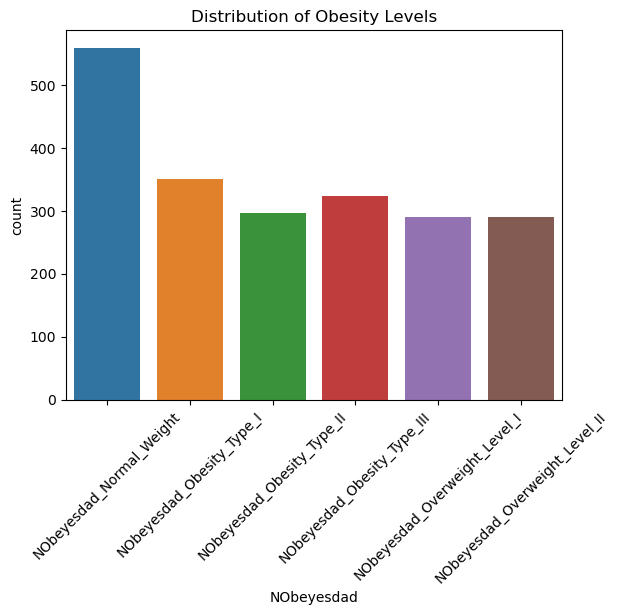

In [9]:

import matplotlib.pyplot as plt
import seaborn as sns

# Visualise the distribution of obesity levels
sns.countplot(x='NObeyesdad', data=df)
plt.title('Distribution of Obesity Levels')
plt.xticks(rotation=45)
plt.show()


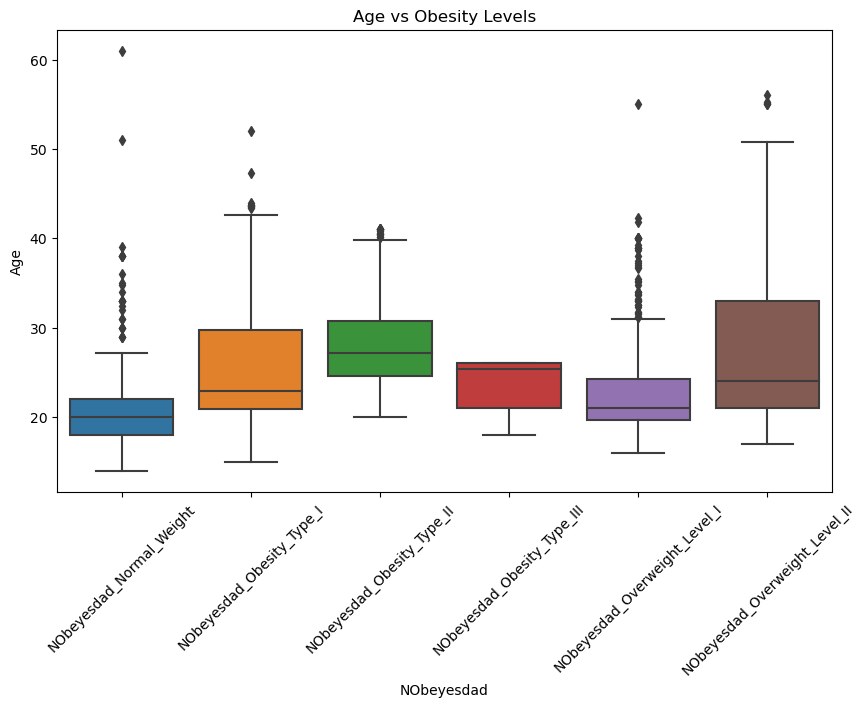

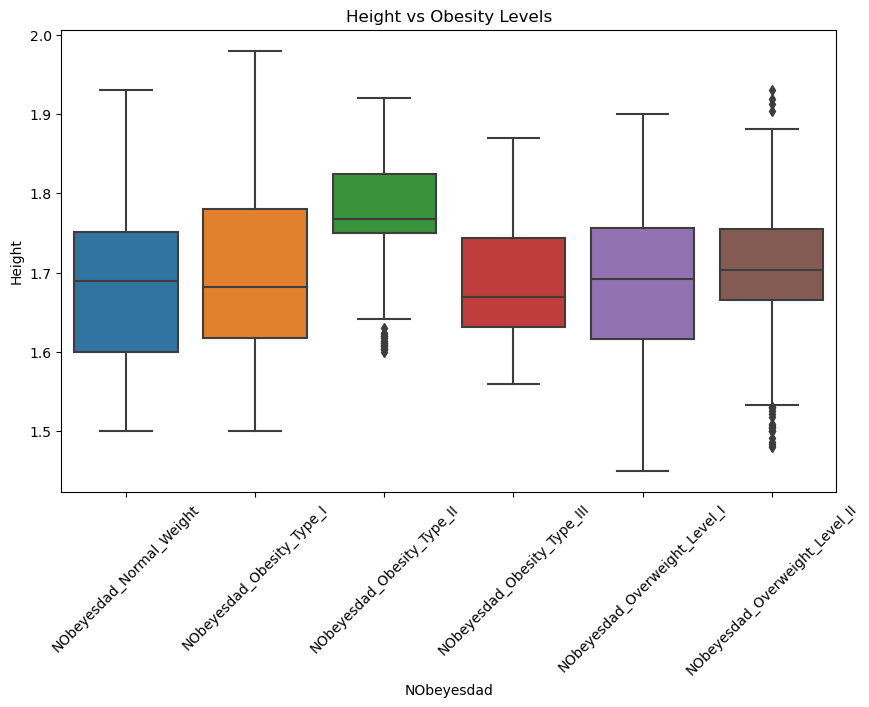

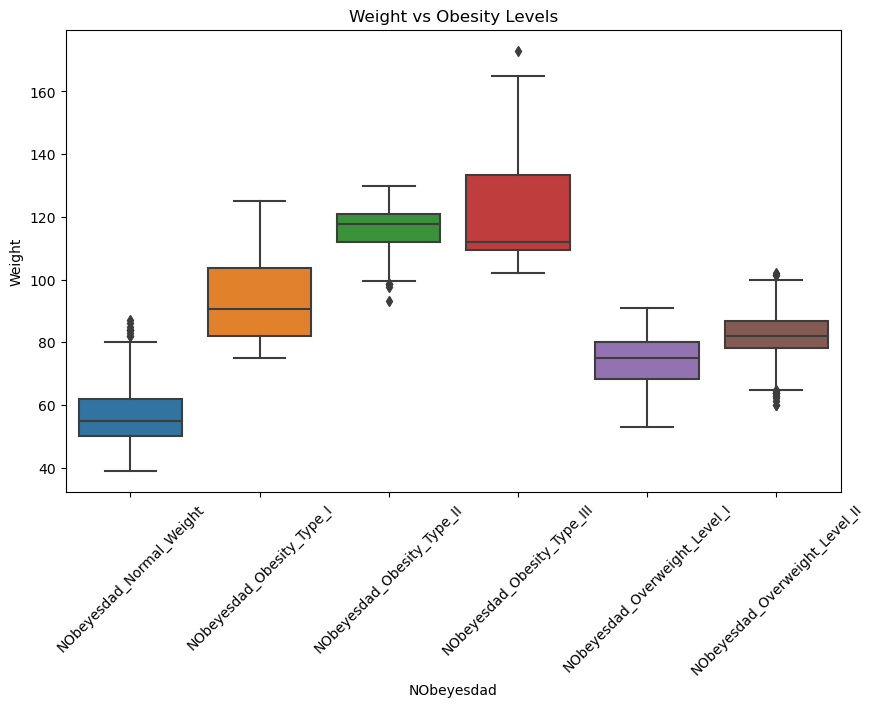

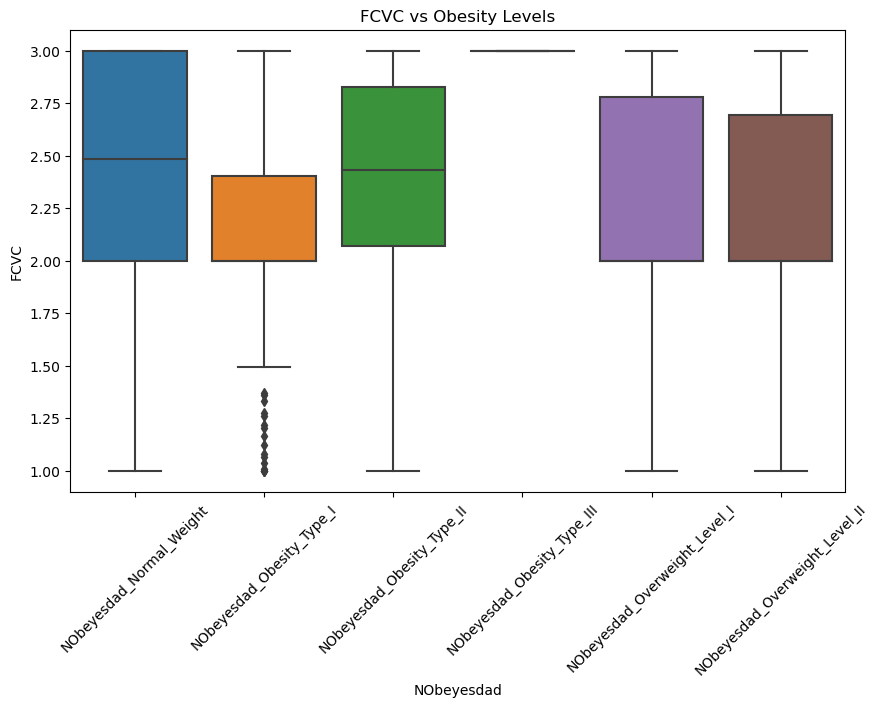

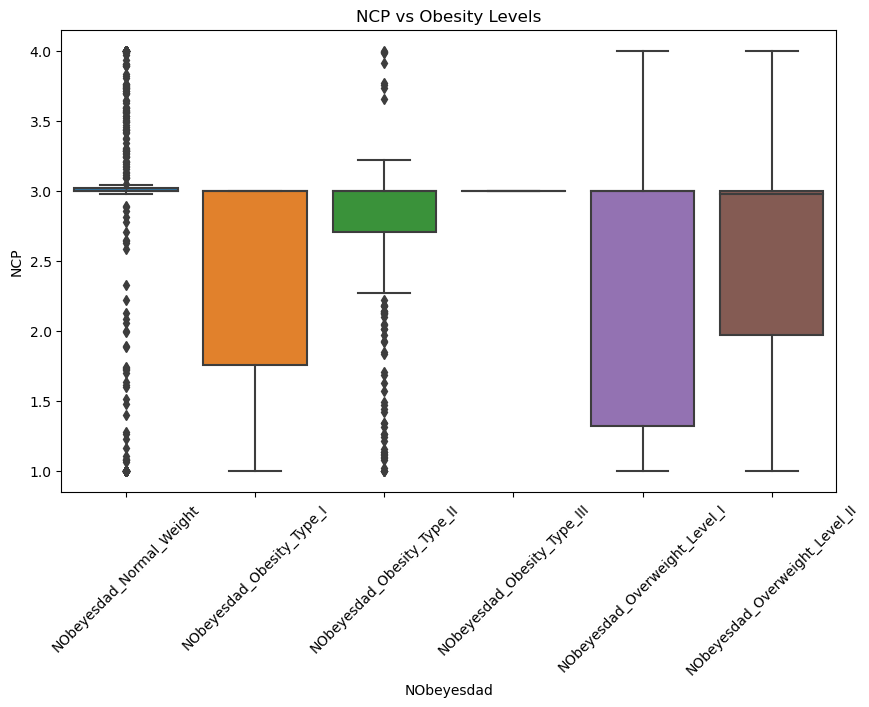

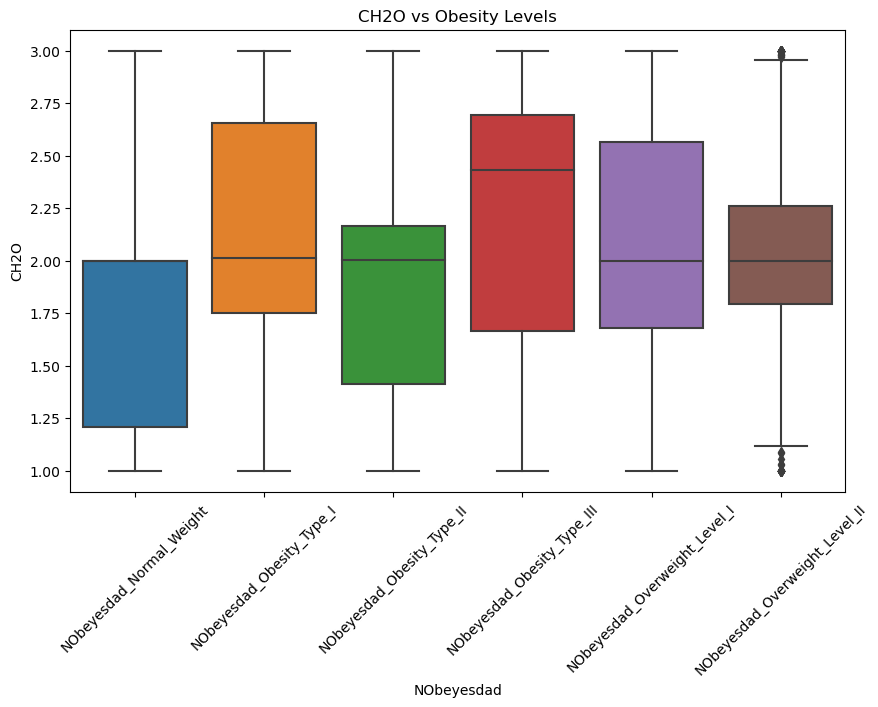

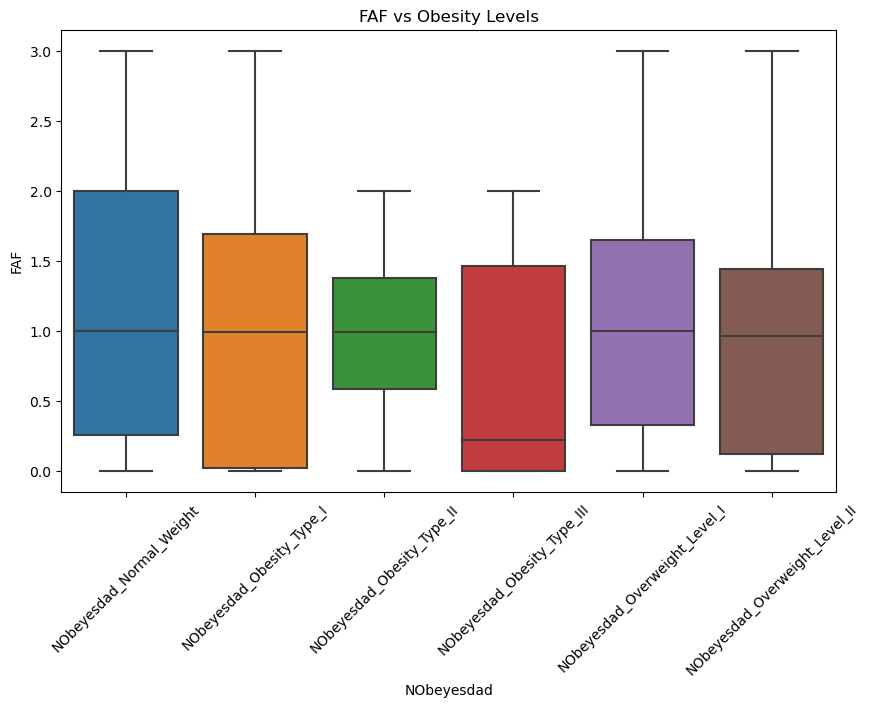

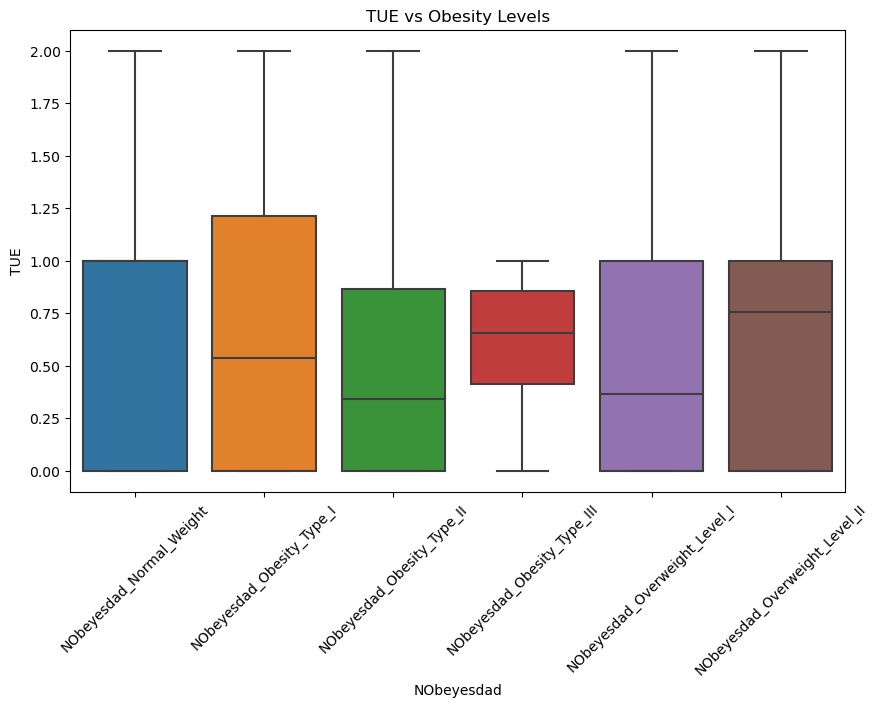

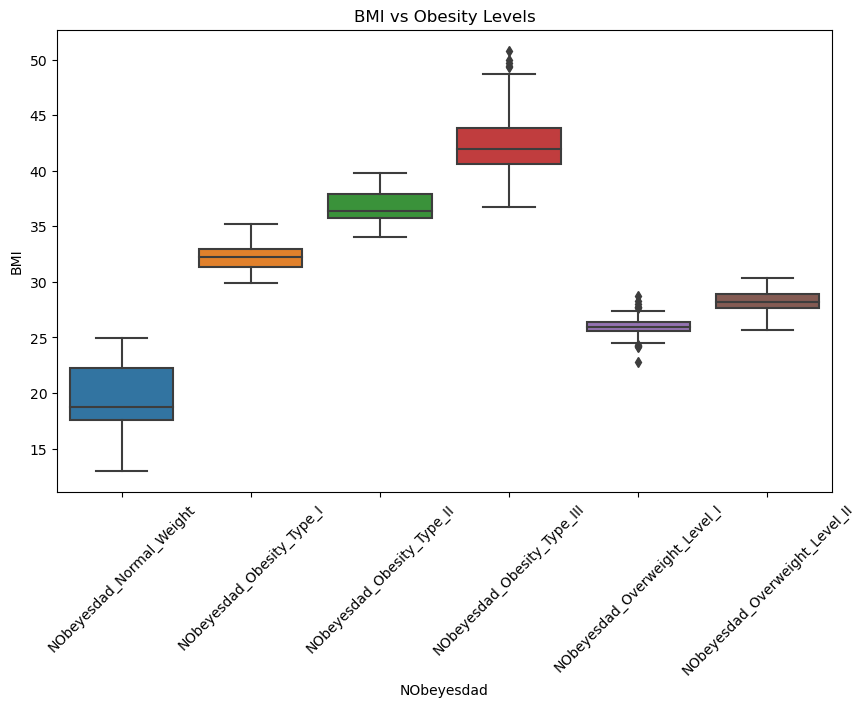

In [10]:

# Visualise the relationship between numeric features and obesity levels
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

for column in numeric_columns:  
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='NObeyesdad', y=column, data=df)
    plt.title(f'{column} vs Obesity Levels')
    plt.xticks(rotation=45) 
    plt.show()


## Feature Engineering

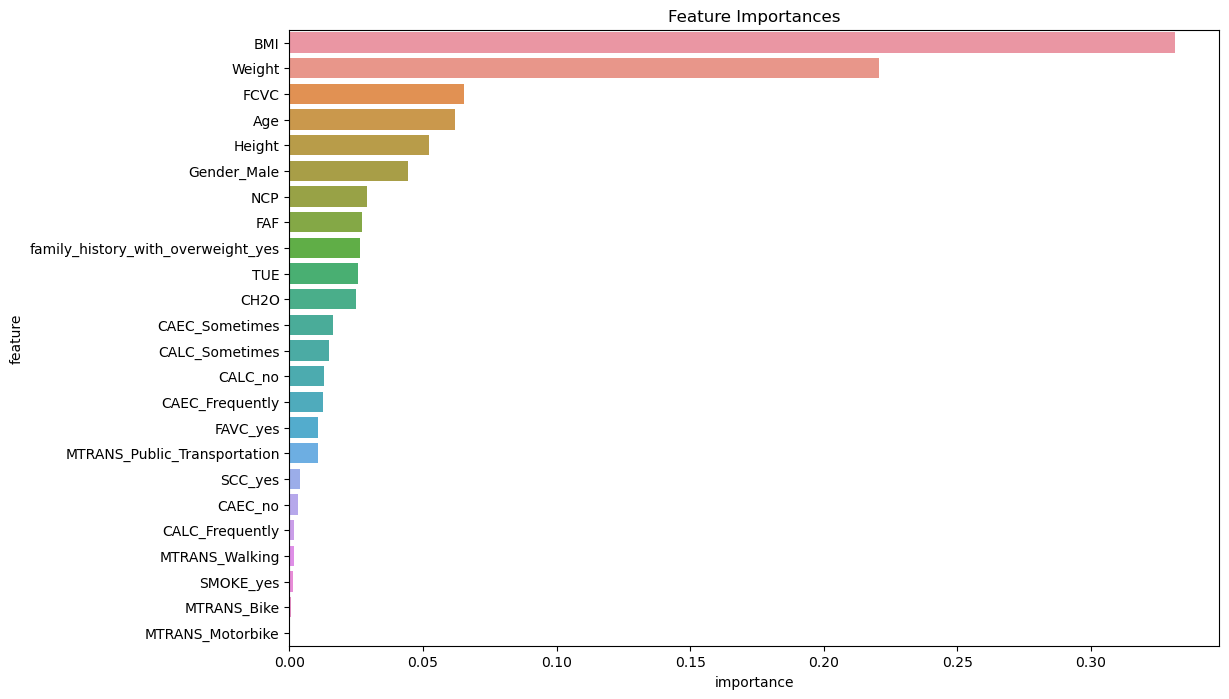

In [5]:

# Create new feature 'BMI'
df['BMI'] = df['Weight'] / (df['Height'] ** 2)

# Analyse feature importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Split data into features and target variable
X = df.drop('NObeyesdad', axis=1)
y = df['NObeyesdad']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Get feature importances
importances = model.feature_importances_
feature_names = X.columns
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.title('Feature Importances')
plt.show()


## Model Building

In [6]:

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Train a Logistic Regression model
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)

# Make predictions
y_pred = logreg.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')


Accuracy: 0.88
Precision: 0.89
Recall: 0.88
F1 Score: 0.88


/Users/stephannieadey/anaconda3/envs/myfirstpythonenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Model Optimisation

In [7]:

from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'saga']
}

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f'Best Parameters: {best_params}')
print(f'Best Cross-Validation Score: {best_score:.2f}')

# Evaluate the optimised model on the test set
optimized_model = grid_search.best_estimator_
y_pred_optimized = optimized_model.predict(X_test)

# Evaluate the optimised model
accuracy_optimized = accuracy_score(y_test, y_pred_optimized)
precision_optimized = precision_score(y_test, y_pred_optimized, average='weighted')
recall_optimized = recall_score(y_test, y_pred_optimized, average='weighted')
f1_optimized = f1_score(y_test, y_pred_optimized, average='weighted')

print(f'Optimized Accuracy: {accuracy_optimized:.2f}')
print(f'Optimized Precision: {precision_optimized:.2f}')
print(f'Optimized Recall: {recall_optimized:.2f}')
print(f'Optimized F1 Score: {f1_optimized:.2f}')


/Users/stephannieadey/anaconda3/envs/myfirstpythonenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/stephannieadey/anaconda3/envs/myfirstpythonenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://s

Best Parameters: {'C': 100, 'solver': 'lbfgs'}
Best Cross-Validation Score: 0.91
Optimized Accuracy: 0.93
Optimized Precision: 0.93
Optimized Recall: 0.93
Optimized F1 Score: 0.93


/Users/stephannieadey/anaconda3/envs/myfirstpythonenv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/stephannieadey/anaconda3/envs/myfirstpythonenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
